# Melodic similarity and distance metrics

This notebook demonstrates very simple way how to compute similarity between different melodies. We focus on folk songs, thus the phrase identification is done as simple as cutting the song into several pieces of equal duration. We focus on computing melody similarity between those phrases that hopefully should correlate with subjective impression. 

Notebook prepared by Philip Tovstogan for MIR course

In [1]:
# Import modules
import os
import numpy as np
import scipy.spatial.distance as dist
import urllib.request as req
import matplotlib.pyplot as plt
import music21 as m21
%matplotlib inline

In [2]:
# Create data directory if not existent
data_dir = 'data'
try:
    os.mkdir(data_dir)
except FileExistsError:
    pass

# Download data
url = 'http://kern.humdrum.org/cgi-bin/ksdata?file={}.krn&l=essen/europa/ukraina&format={}'
files = ['ukrain04', 'ukrain06', 'ukrain07']
for file in files:
    for fmt, ext in [('kern', 'krn'), ('midi', 'mid')]:
        req.urlretrieve(url.format(file, fmt), os.path.join(data_dir, file + '.' + ext))

# Helper function that returns full path to downloaded file 
def path(file):
    return os.path.join(data_dir, files[0] + '.krn')

First, let's do some visual analysis of the first file

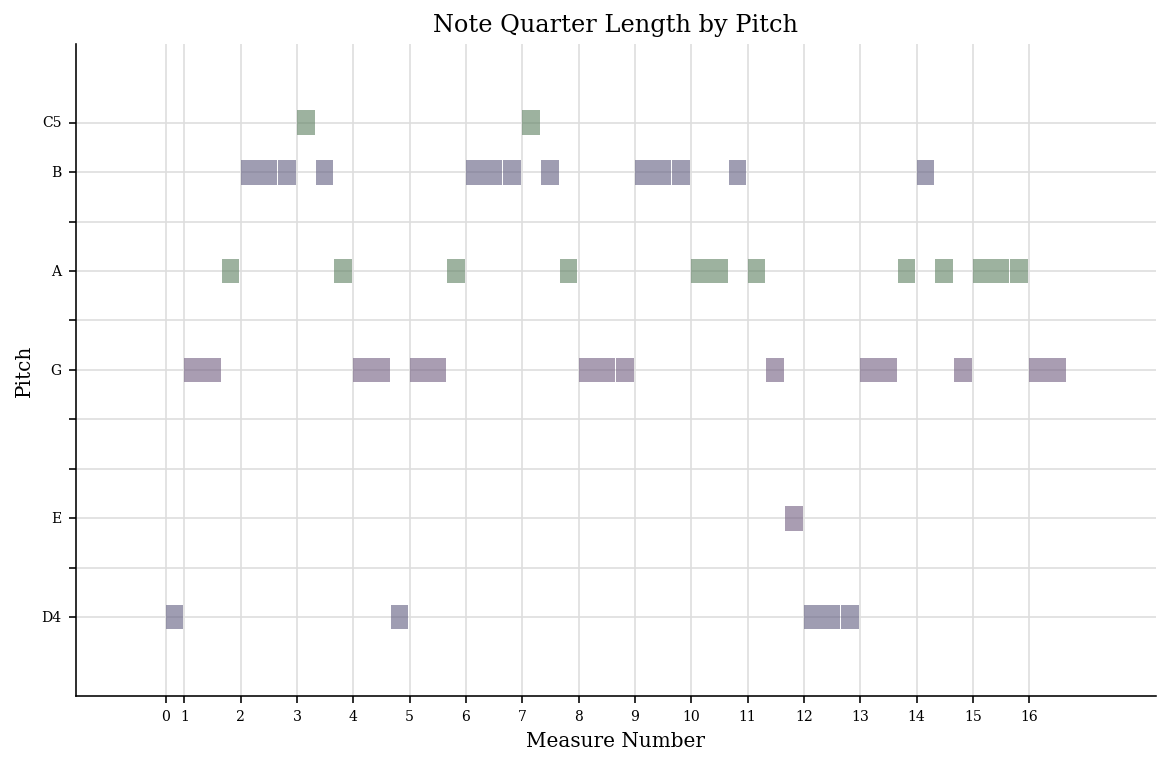

In [3]:
# Plot the piano roll of the midi file
data = m21.converter.parse(path(files[0]))
data.plot()

From the figure above that represents piano roll, you can see that this is a very simple melody (it is usually the case for folk songs). The whole tune can be split into 4 phrases with equal duration, so we will use this method to split the melody into N phrases 

## Visualizing melody contours

In [4]:
def get_phrase_contours(notes, n_phrases):
    # Split equally by duration into N phrases
    phrases = [[] for i in range(n_phrases)]
    phrase_duration = notes.duration.quarterLength / n_phrases

    index = 0
    min_duration = 1.0
    current_duration = 0

    for note in notes:
        phrases[index].append(note)
        current_duration += note.duration.quarterLength  # accumulate the duration of the phrase
        min_duration = min(min_duration, note.duration.quarterLength)  # later to be used to create vectors of equal length

        if(current_duration >= phrase_duration):  # start new phrase when at the end
            index += 1
            current_duration -= phrase_duration
    
    # Create vectors that can be compared
    contours = []
    max_len = 0
    
    for phrase in phrases:
        ref_midi = None
        contour = []

        midi_relative = None

        for note in phrase:
            if type(note) is not m21.note.Rest:
                if ref_midi is None:
                    ref_midi = note.pitch.midi  # set the reference note (first in phrase)
            
                midi_relative = note.pitch.midi - ref_midi
                
            # else skip the rests if they are in the beginning of the phrase
            
            if midi_relative is not None:
                duration = int(np.ceil(note.duration.quarterLength / min_duration))
                contour += [midi_relative] * duration  # add the note as repetitions of itself
        
        max_len = max(max_len, len(contour))
        contours.append(contour)

    # Make sure all vectors are of the same length, pad shorter ones
    for contour in contours:
        contour += [contour[-1]] * (max_len - len(contour))
        
    return np.array(contours)

# Calculate the contours
n_phrases = 4  # we get this number from initial brief analysis (visual or aural)
notes = data.recurse().notesAndRests
contours = get_phrase_contours(notes, n_phrases)

Text(0.5,1,'Phrase melody visualization')

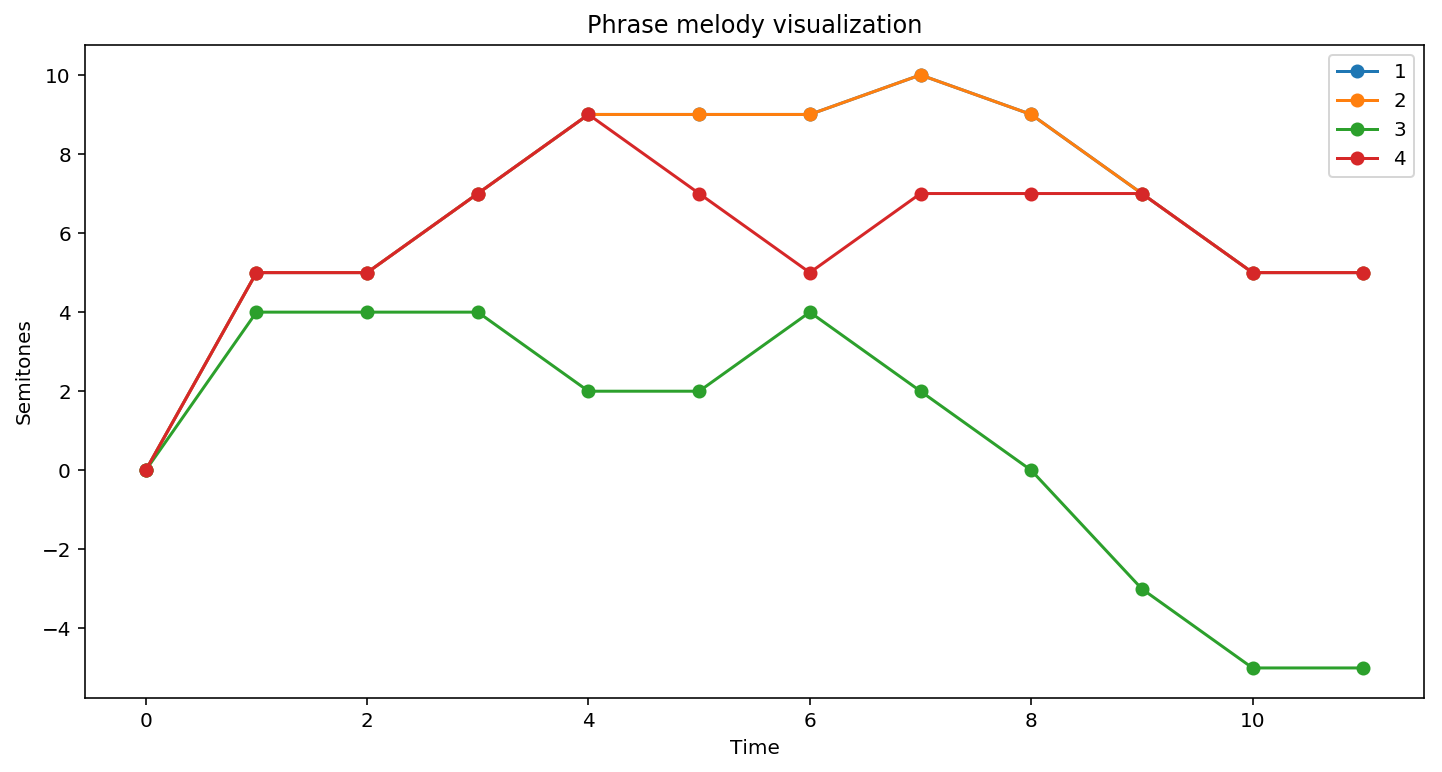

In [5]:
# Plot the contours for visual comparison of the phrases
plt.figure(figsize=(12, 6))
ax = plt.gca()
for contour in contours:
    ax.plot(contour, marker='o')

plt.legend(np.arange(n_phrases) + 1)
ax.set_ylabel('Semitones')
ax.set_xlabel('Time')
ax.set_title('Phrase melody visualization')

We cannot see the first phrase at all because it is completely covered by phrase 2, thus being totally the same (as we heard before). Thus, 1st and 2nd phrases should get the lowest distance. 3rd phrase goes down and it the most different one, while the 4th beginning and ending resemble first two.

## Measuring distance
There are many different distance metrics that can be used, but we will focus on:

* Cityblock (L1)
* Euclidean (L2)
* Correlation ($1 - \frac{ (u - \bar{u}) (v - \bar{u})} {|u - \bar{u}| |v - \bar{u}| }$)

The melodies are basically considered to be 1D vectors and we want to compute the distance between them in N-dimensional space.

In [6]:
metrics = ['euclidean', 'cityblock', 'correlation']
results = {}
for metric in metrics:
    results[metric] = dist.pdist(contours, metric=metric)

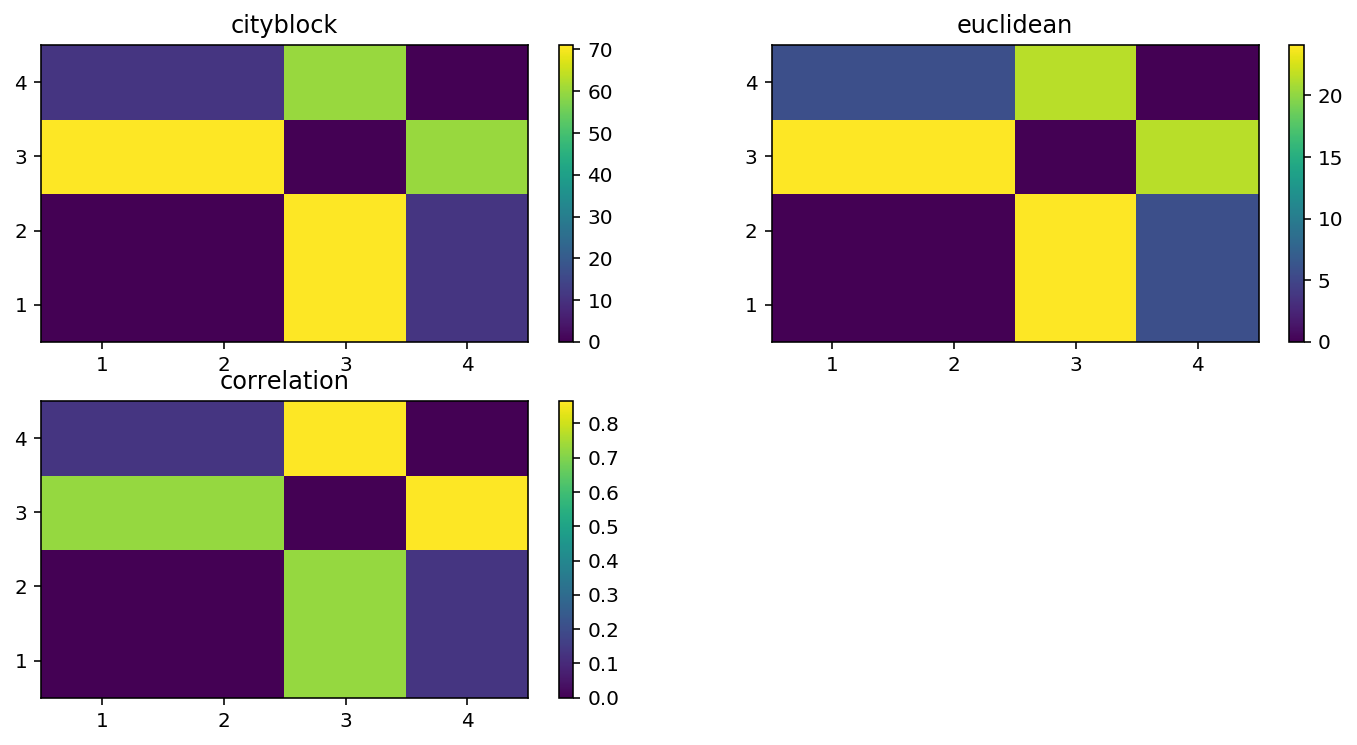

In [7]:
def plot_distance_matrix(distances, title):
    # because the input is in condenced form, we need to unwrap it first
    matrix = dist.squareform(distances)
    
    plt.pcolor(matrix)
    plt.colorbar()
    
    ax = plt.gca()
    ax.set_title(title)
    ticks = np.arange(len(matrix)) + 0.5
    labels = np.arange(len(matrix)) + 1
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)


num_plots = len(metrics)
plt.figure(figsize=(12, num_plots*2))

index = 1
for metric, distances in results.items():
    plt.subplot(np.ceil(num_plots/2), 2, index)
    plot_distance_matrix(distances, metric)
    index +=1
    

We can see how the choice of the metric matters: while L1 (cityblock) distance indicates 2nd and 3rd as most dissimilar, correlation distance indicates that those are 3rd and 4th. L2 is pretty consistend with L1.

## Compare several melodies
Let's do the phrase similarity analysis for the several melodies and see if there is any insight to be gained.

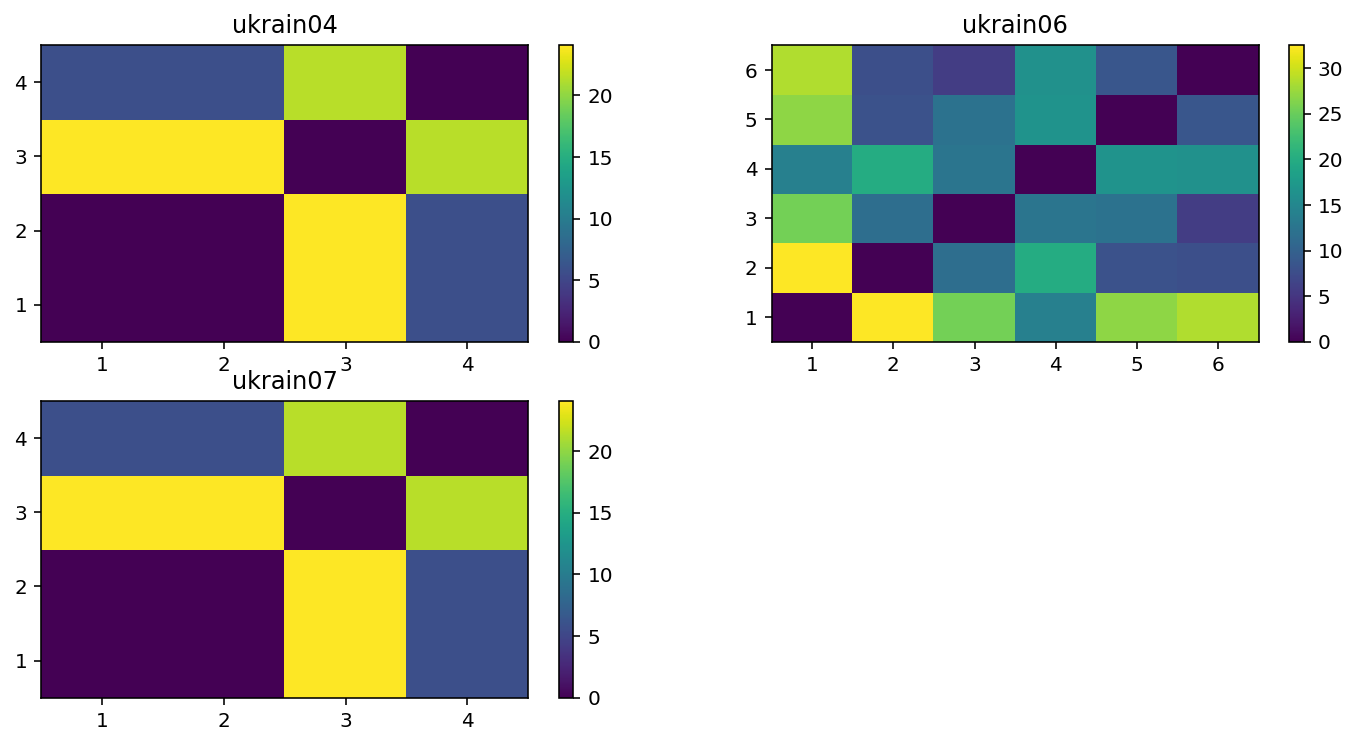

In [8]:
# Provide input file and number of phrases and retrieve the distance matrix
def get_phrase_distances(filename, n_phrases, metric='euclidean'):
    data = m21.converter.parse(filename)
    notes = data.recurse().notesAndRests
    contours = get_phrase_contours(notes, n_phrases)
    return dist.pdist(contours, metric=metric)

n_phrases_list = [4, 6, 4]
total = len(files)

plt.figure(figsize=(12, total*2))
index = 1

# For each file compute distances and plot them
for i in range(total):
    distances = get_phrase_distances(path(files[i]), n_phrases_list[i])
    plt.subplot(np.ceil(total/2), 2, index)
    plot_distance_matrix(distances, files[i])
    index += 1

We can see that even that `ukrain04` and `ukrain07` melodies are totally different, the structure and similarity of phrases follows the same pattern, what is representative of folk songs. 